In [10]:
import numpy as np
import gurobipy as gb
import pylab as pl

import seaborn as sns
sns.set_theme()

from src import *

# TSDAP
## Time Dependent Activity Scheduling Problem

### Problem definition



$\tau_i(t_i)$ is the time required to complete activity $i$ at time $t_i$.  
$e_i, l_i$ are the earliest start time and latest end time of activity $i$.  
$\rho_i(t_i)$ is the resource consumption of activity $i$ at time $t_i$.  
$Q$ is the total resource capacity  
$\theta_i(t_i) = t_i + \tau_i(t_i)$ is the completion time function.  

Minimize
$$\min_{t_j} \theta_n(t_n) = \min_{t_j} t_n + \tau_n(t_n)$$

subject to
$$\theta_i(t_i) \le t_{i+1}$$
$$\sum_{i=1}^{n} \rho_i(t_i) \le Q$$
$$t_i \in [e_i, l_i]$$

We assume the FIFO property: $\theta_i(t) \le \theta_i(t')$ if $t \le t'$

#### Solve TSDAP

$V_i = \{e_i, e_i + \epsilon, ..., l_i \}$ set of vertices for activity $i$  
$V = V_1 \cup ... \cup V_n$  
$q_{(i,t)} = \rho_i(t)$  
$l_{(i,t)}$ cumulative resource consumption prior to starting activity $i$ at time $t_i$.  
$W = \{(i, t) \in V \setminus \bar V \; | \; l_{(i, t)} + q_{(i,t)} \le Q\}$ set of still available vertices.


![](algorithm_1.png)

#### Implemented solution

The implemented algorithm differs from the one described in the paper by using a MinHeap to store the vertexes $W$ instead of a sorted list. This choice was made by analyzing the time complexity of the two algorithms, with the sorted list implementation taking time $O(n^2m^2)$ to keep it sorted, while the MinHeap implementation takes time $O(nm\log(mn)) = O(nm)$ if $n=am$ for $a>0$ which is the case of the article. This enhanced version of the algorithm has also been discussed with the authors of the paper, who agree on the complexity.  

### Data Model

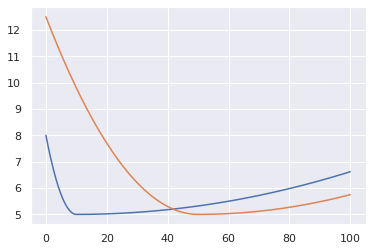

In [11]:
speeds = np.linspace(0, 100, 1000)

pl.plot(speeds, [ev_consumption(s) for s in speeds])
pl.plot(speeds, [gasoline_consumption(s) for s in speeds])

We consider the problem of delivering n packages in a big city with time-dependent congestions. We assume that the order of delivery of the packages has already been optimized by a routing algorithm and we seek a further optimization as to when to start each delivery in order to complete all of them as soon as possible.

We generate the data as follows:  
* The city is modelled as a traffic distribution over 2D space, which is peaked at the center of the city, and a traffic distribution over time, with two peaks during peak hours (8am and 5pm).
* The congestion level is a function of both these two functions and is computed as follows: 
```python
traffic = 1 / (1 - traffic_over_time(time))
sensitivity = traffic_over_space(point)
congestion = traffic*sensitivity + 1-sensitivity
```

The least amount of congestion is 1 while the maximum amount is capped at 5, not shown in the code above

Text(0.5, 0, 'Time of day [hours]')

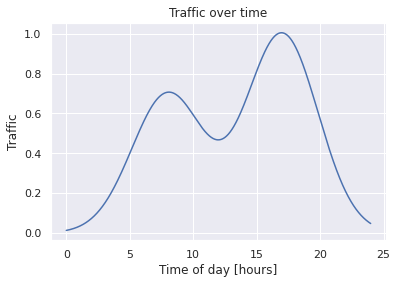

In [12]:
# Traffic over time, shape taken from https://www.tomtom.com/en_gb/traffic-index/new-york-traffic/
t = np.arange(0, 24*60)
pl.plot(t/60, traffic_over_time(t))
pl.title("Traffic over time")
pl.ylabel("Traffic")
pl.xlabel("Time of day [hours]")

Text(0.5, 0, 'x [km]')

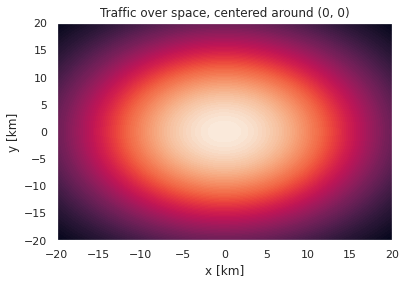

In [13]:
# Traffic over space, a gaussian distribution centered around (0, 0)
x = np.linspace(-20, 20, 40)
y = np.linspace(-20, 20, 40)
xx, yy = np.meshgrid(x, y)
zz = []
pl.contourf(xx, yy, traffic_over_space((xx, yy)), 100)
pl.title("Traffic over space, centered around (0, 0)")
pl.ylabel("y [km]")
pl.xlabel("x [km]")

In [5]:
# A traffic model gives the traffic at a specified time and place in a city
model = TrafficModel(traffic_over_space, traffic_over_time)

Once a traffic model has been created we use it to compute the travel time of the routes.  
A route goes from point A to point B always in a straight line, and we compute the time taken by integration
$$x \rarr x+dx\\
t \rarr t + \mathrm{traffic}(x, t)dx$$
or
$$\partial t / \partial x = \mathrm{traffic}(x, t)$$

the time to compute the while this approach is not realistic in terms of travel time, we need to evalutate the scalability of the implmented solutions so we don't need a perfect model of a city.

In [9]:
x = 10.
route = Route(model, gasoline_consumption, np.array((0., 0.)), np.array((x, x)), base_speed=50)
route.travel_time(700)

32.081308616243405

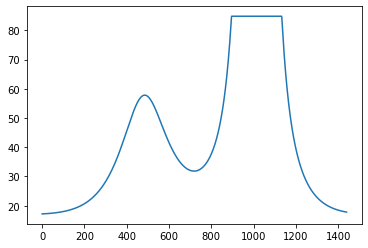

In [10]:
t = np.arange(0, 24*60)

traffic = [route.travel_time(i) for i in t]

pl.plot(t, traffic)

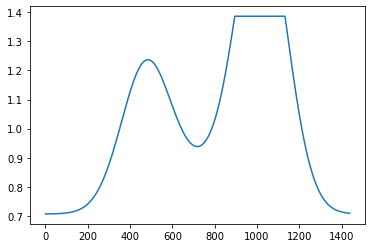

In [11]:
t = np.arange(0, 24*60)

traffic = [route.resources_consumed(i) for i in t]

pl.plot(t, traffic)

In [17]:
n_activities = 30
Q = 2*n_activities
eps = 1.
discretizer = TimeDiscretizer(eps)
activities = [Activity(60*i, 60*(i+1), my_tau, my_rho) for i in range(n_activities)]

V = []
q = []
for activity in activities:
    times = discretizer.discretize_activity(activity)
    V.append(dict([(i, time) for i, time in enumerate(times)]))
    q.append(dict([(i, activity.resources(time)) for i, time in enumerate(times)]))

In [18]:
%timeit sol = TEN_solve(V, activities, q, Q)
sol

79.3 ms ± 187 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Completion time: 421.59
Resources consumed: 12.78
Nodes visited: 39

In [19]:
%timeit sol = DDD_solve(activities, Q, discretizer)
sol

121 ms ± 341 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Completion time: 421.59
Resources consumed: 12.78
Nodes visited: 39

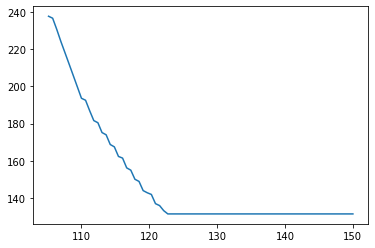

In [20]:
a = []
Qs = []
for Q in np.linspace(1.5*n_activities, 2.5*n_activities, 100):
    sol = TEN_solve(V, activities, q, Q)
    if sol is not None:
        Qs.append(Q)
        a.append(sol.completion_time())

pl.plot(Qs, a)

## Gurobi

In [ ]:
tdasp = gb.Model()
x = tdasp.addMVar((n_activities, n_steps), vtype=gb.GRB.BINARY)

In [ ]:
assignment = gb.Model()
assignment.modelSense = gb.GRB.MINIMIZE #declare mimization

# assignment.setParam('OutputFlag', 0) suppress outputs, equivalent of xpress setControl('outputlog', 0)

X = assignment.addVars( [(i,j) for i in range(4) for j in range(4)], vtype=gb.GRB.BINARY) #this way of declare vars does not allow to work with matrix multiplication (X is a tuple dict)

I = range(4)
J = range(4)

costs = np.array([[13,	4,	7, 6],
                	[1,	11,	5, 4],
                  [6,	7,	2, 8],
                  [1,	3,	5, 9]])


for i in I:
  assignment.addConstr( gb.quicksum(X[i,j] for j in J) <= 1) #quicksum is the equivalent to xp.Sum

for j in J:
  assignment.addConstr( gb.quicksum(X[i,j] for i in I) == 1 )

assignment.setObjective( 
    gb.quicksum( costs[i,j]*X[i,j]   for j in J for i in I)
    )   

assignment.optimize() #equivalent to solve() for xpress


Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 8 rows, 16 columns and 32 nonzeros
Model fingerprint: 0x6f06b897
Variable types: 0 continuous, 16 integer (16 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 24.0000000
Presolve time: 0.00s
Presolved: 8 rows, 16 columns, 32 nonzeros
Variable types: 0 continuous, 16 integer (16 binary)

Root relaxation: objective 1.100000e+01, 6 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      11.0000000   11.00000  0.00%     -    0s

Explored 1 nodes (